In [ ]:
### TODO
#
# - clean the graph to simplify the problem
#   - FORMAT 1
#        - for nodes with multiple transactions between themselves, keep only one directed adge - remove all others. This edge will contain the number of transactions and the average amount of those transactions
#
#
#
#

In [143]:
import pandas as pd
import networkx as nx
import numpy as np

# Read in the CSV files

# 0.1%
accounts_df = pd.read_csv("../datasets/p_0_1_percent/PS_20230428161042_1211346587/PS_20230428161042_1211346587_account_attributes.csv")
transactions_df = pd.read_csv("../datasets/p_0_1_percent/PS_20230428161042_1211346587/PS_20230428161042_1211346587_rawLog.csv")

# 1%
#accounts_df = pd.read_csv("../datasets/p_1_percent/PS_20230504121043_87775/PS_20230504121043_87775_account_attributes.csv")
#transactions_df = pd.read_csv("../datasets/p_1_percent/PS_20230504121043_87775/PS_20230504121043_87775_rawLog.csv")

# 5%
#accounts_df = pd.read_csv("../datasets/p_5_percent/PS_20230504134819_26105/PS_20230504134819_26105_account_attributes.csv")
#transactions_df = pd.read_csv("../datasets/p_5_percent/PS_20230504134819_26105/PS_20230504134819_26105_rawLog.csv")

# 10%
#accounts_df = pd.read_csv("")
#transactions_df = pd.read_csv("")

# 20%
#accounts_df = pd.read_csv("")
#transactions_df = pd.read_csv("")





In [144]:
nodes_df = accounts_df
edges_df = transactions_df


nodes_df.head()
edges_df.head()

,step,action,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud,isUnauthorizedOverdraft
0,0,TRANSFER,13.46,C9085655831,13.46,0.0,CC6839167080,0.0,13.46,1,0,0
1,0,CASH_OUT,13.46,CC6839167080,13.46,0.0,M8014678677,0.0,0.00,1,0,0
2,0,TRANSFER,457144.87,C6251180045,457144.87,0.0,CC2721410980,0.0,457144.87,1,0,0
3,0,CASH_OUT,457144.87,CC2721410980,457144.87,0.0,M7504823709,0.0,0.00,1,0,0
4,1,CASH_IN,58431.97,C1415598458,34.93,58466.9,M1766118549,0.0,0.00,0,0,0


In [145]:
# create dummies for the 'action' column
dummies = pd.get_dummies(edges_df.action, prefix='action')

# concatenate the dummies to the original DataFrame
edges_df = pd.concat([edges_df, dummies], axis=1)

# drop the original 'action' column
edges_df.drop('action', axis=1, inplace=True)

edges_df.head()

,step,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud,isUnauthorizedOverdraft,action_CASH_IN,action_CASH_OUT,action_DEBIT,action_PAYMENT,action_TRANSFER
0,0,13.46,C9085655831,13.46,0.0,CC6839167080,0.0,13.46,1,0,0,0,0,0,0,1
1,0,13.46,CC6839167080,13.46,0.0,M8014678677,0.0,0.00,1,0,0,0,1,0,0,0
2,0,457144.87,C6251180045,457144.87,0.0,CC2721410980,0.0,457144.87,1,0,0,0,0,0,0,1
3,0,457144.87,CC2721410980,457144.87,0.0,M7504823709,0.0,0.00,1,0,0,0,1,0,0,0
4,1,58431.97,C1415598458,34.93,58466.9,M1766118549,0.0,0.00,0,0,0,1,0,0,0,0


In [146]:
# Now we compute numerical indices for nameOrig and nameDest rather than their form 'CC6839167080'

# Create a dictionary that maps each unique original name to a new unique ID
node_ids = {node_name: i for i, node_name in enumerate(set(edges_df['nameOrig']).union(set(edges_df['nameDest'])))}


# Replace the original names with the new IDs
edges_df['nameOrig'] = edges_df['nameOrig'].map(node_ids)
edges_df['nameDest'] = edges_df['nameDest'].map(node_ids)

edges_df.head()

,step,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud,isUnauthorizedOverdraft,action_CASH_IN,action_CASH_OUT,action_DEBIT,action_PAYMENT,action_TRANSFER
0,0,13.46,43808,13.46,0.0,4941,0.0,13.46,1,0,0,0,0,0,0,1
1,0,13.46,4941,13.46,0.0,27613,0.0,0.00,1,0,0,0,1,0,0,0
2,0,457144.87,27337,457144.87,0.0,41354,0.0,457144.87,1,0,0,0,0,0,0,1
3,0,457144.87,41354,457144.87,0.0,49738,0.0,0.00,1,0,0,0,1,0,0,0
4,1,58431.97,48330,34.93,58466.9,31897,0.0,0.00,0,0,0,1,0,0,0,0


In [147]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)
# Helper function for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from torch_geometric.transforms import NormalizeFeatures

def visualize(h, color):
    z = TSNE(n_components=2, learning_rate='auto',
             init='random').fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

def print_model_size(model):
    tot = sum([p.numel() for p in model.parameters() if p.requires_grad])
    out = f"Number of model ({model.__class__.__name__}) parameters:{tot:10d}"
    print("=" * len(out))
    print(out)

2.0.0


In [148]:
x_np = nodes_df.to_numpy()
x = x_np[:,0:-3]
x.shape

(55539, 41)

In [149]:
from torch.utils.data import random_split
# Define your graph
x = torch.nn.functional.normalize(torch.tensor(x),dim=0).to(torch.float32)  # (n x features)
edge_index =  torch.stack([torch.tensor(edges_df.nameOrig.to_numpy()),torch.tensor(edges_df.nameDest.to_numpy())],dim=-1).T  # Define your edge index
edge_attr = torch.nn.functional.normalize(torch.tensor(np.array(edges_df[['amount','oldBalanceOrig', 'newBalanceOrig', 'oldBalanceDest', 'newBalanceDest','isFlaggedFraud','isUnauthorizedOverdraft','action_CASH_IN','action_CASH_OUT','action_DEBIT','action_PAYMENT','action_TRANSFER']].values,dtype='float32')),dim=0) # edge features
y =  torch.tensor(nodes_df.node_isFraud.to_numpy().astype(int)) # target values

train_size = int(0.6 * len(y))  # 60% of the dataset for training
val_size = int(0.2 * len(y))    # 20% of the dataset for validation
test_size = len(y) - train_size - val_size  # Remaining 20% for testing

train_dataset, val_dataset, test_dataset = random_split(y, [train_size, val_size, test_size])

# Create masks for train, validation, and test sets
train_mask = torch.zeros(len(y), dtype=torch.bool)
val_mask = torch.zeros(len(y), dtype=torch.bool)
test_mask = torch.zeros(len(y), dtype=torch.bool)

train_mask[train_dataset.indices] = True
val_mask[val_dataset.indices] = True
test_mask[test_dataset.indices] = True

In [74]:
edge_attr.dtype

torch.float32

In [150]:
from torch_geometric.data import Data
# Load your data into PyTorch Geometric's Data class
data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y,train_mask=train_mask, val_mask=val_mask, test_mask=test_mask)


In [151]:
# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')

print('==============================')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')
print(f'Is weighted: {data.edge_weight is not None}')

print('==============================')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')

Number of nodes: 55539
Number of edges: 3225140
Average node degree: 58.07
Has isolated nodes: False
Has self-loops: False
Is undirected: False
Is weighted: False
Number of training nodes: 33323
Training node label rate: 0.60


In [152]:
import torch

from torch.nn import Linear
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import degree


def random_walk_matrix(edge_index, num_nodes: int = None):
    source, target = edge_index[0], edge_index[1]
    in_deg = degree(target, num_nodes=num_nodes)   # D
    edge_weight = 1 / in_deg[target]               # D^-1 A
    return edge_index, edge_weight


class MPNN(MessagePassing):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__(aggr="add")                         # "sum" aggregation
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.lin_message = Linear(in_channels, out_channels, # weights 𝚯_1
                                  bias=False)
        self.lin_update = Linear(in_channels, out_channels,  # weights 𝚯_2
                                 bias=True)                  # the bias vector 𝐛

    def forward(self, x, edge_index, edge_weight=None):
        # 0. if GSO not already computed, compute it here
        if edge_weight is None:
          _, edge_weight = random_walk_matrix(edge_index)
        # 1. m_j→𝑖 = x_j𝚯_1
        m_ji = self.lin_message(x)  # we can project here with isotropic GNNs
        # 2. m_𝑖 = add(ã_ji ⋅ m_j→𝑖)_j∈𝑁(i)
        m_i = self.propagate(edge_index, m=m_ji, edge_weight=edge_weight)
        # 3. h_𝑖 = tanh(x_i𝚯_2 + m_i + 𝐛)
        h_i = torch.tanh(self.lin_update(x) + m_i)
        return h_i

    def message(self, m_j, edge_weight):
        return edge_weight.view(-1, 1) * m_j  # ã_ji ⋅ m_j→𝑖

In [153]:
gso_index, gso_weight = random_walk_matrix(data.edge_index, data.num_nodes)
print(f"Edge weights: {gso_weight}")
print(gso_index)

Edge weights: tensor([0.0588, 0.0116, 0.0714,  ..., 0.0122, 1.0000, 0.0128])
tensor([[43808,  4941, 27337,  ..., 15117,  8376, 24000],
        [ 4941, 27613, 41354,  ..., 45408, 24000, 41810]])


In [154]:
a = torch.tensor([0,1,2,3,0,0])
deg = degree(a, num_nodes=None)
deg[a] #UNUSUAL BEHAVIOUR I DID NOT KNOW ABOUT

tensor([3., 1., 1., 1., 3., 3.])

In [155]:
import torch

from torch.nn import Linear

HIDDEN_SIZE = 16 #@param
NUM_LAYERS = 2 #@param

dataset_num_features = x.size()[1]
dataset_num_classes = 2

class GNNModel(torch.nn.Module):

    def __init__(self, hidden_size: int,
                 num_layers: int = 1):
        super().__init__()
        torch.manual_seed(12345)

        self.mpnns = torch.nn.ModuleList()
        for l in range(num_layers):
            in_size = dataset_num_features if l == 0 else hidden_size
            mpnn = MPNN(in_channels=in_size, out_channels=hidden_size)
            self.mpnns.append(mpnn)

        self.lin_out = Linear(hidden_size, dataset_num_classes)
    
    def forward(self, x, edge_index, edge_weight=None):
        # Message-passing: transform node features based on neighbors
        for mpnn in self.mpnns:
            x = mpnn(x, edge_index, edge_weight)
        # Decoder: post-process extracted features
        out = self.lin_out(x)
        return out

model = GNNModel(HIDDEN_SIZE, NUM_LAYERS)
print(model)
print_model_size(model)

GNNModel(
  (mpnns): ModuleList(
    (0): MPNN(41, 16)
    (1): MPNN(16, 16)
  )
  (lin_out): Linear(in_features=16, out_features=2, bias=True)
)
Number of model (GNNModel) parameters:      1890


In [156]:
model = GNNModel(HIDDEN_SIZE, NUM_LAYERS)
model.eval()

out = model(data.x, data.edge_index)
#visualize(out, color=data.y)

In [158]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CrossEntropyFocalLoss(nn.Module):
    def __init__(self, gamma=2, weight=None, reduction='mean'):
        super(CrossEntropyFocalLoss, self).__init__()
        self.gamma = gamma
        self.weight = weight
        self.reduction = reduction

    def forward(self, input, target):
        ce_loss = F.cross_entropy(input, target, weight=self.weight, reduction=self.reduction)
        pt = torch.exp(-ce_loss)
        focal_loss = (1 - pt)**self.gamma * ce_loss
        return focal_loss
    

    p_t = p * targets + (1 - p) * (1 - targets)
    loss = ce_loss * ((1 - p_t) ** gamma)



In [170]:
import torch
import torch.nn.functional as F

from torchvision.utils import _log_api_usage_once


def sigmoid_focal_loss(
    inputs: torch.Tensor,
    targets: torch.Tensor,
    alpha: float = 0.25,
    gamma: float = 2,
    reduction: str = "none",
) -> torch.Tensor:
    """
    Loss used in RetinaNet for dense detection: https://arxiv.org/abs/1708.02002.

    Args:
        inputs (Tensor): A float tensor of arbitrary shape.
                The predictions for each example.
        targets (Tensor): A float tensor with the same shape as inputs. Stores the binary
                classification label for each element in inputs
                (0 for the negative class and 1 for the positive class).
        alpha (float): Weighting factor in range (0,1) to balance
                positive vs negative examples or -1 for ignore. Default: ``0.25``.
        gamma (float): Exponent of the modulating factor (1 - p_t) to
                balance easy vs hard examples. Default: ``2``.
        reduction (string): ``'none'`` | ``'mean'`` | ``'sum'``
                ``'none'``: No reduction will be applied to the output.
                ``'mean'``: The output will be averaged.
                ``'sum'``: The output will be summed. Default: ``'none'``.
    Returns:
        Loss tensor with the reduction option applied.
    """
    # Original implementation from https://github.com/facebookresearch/fvcore/blob/master/fvcore/nn/focal_loss.py

    if not torch.jit.is_scripting() and not torch.jit.is_tracing():
        _log_api_usage_once(sigmoid_focal_loss)
    p = torch.sigmoid(inputs)
    ce_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction="none")
    p_t = p * targets + (1 - p) * (1 - targets)
    loss = ce_loss * ((1 - p_t) ** gamma)

    if alpha >= 0:
        alpha_t = alpha * targets + (1 - alpha) * (1 - targets)
        loss = alpha_t * loss

    # Check reduction option and return loss accordingly
    if reduction == "none":
        pass
    elif reduction == "mean":
        loss = loss.mean()
    elif reduction == "sum":
        loss = loss.sum()
    else:
        raise ValueError(
            f"Invalid Value for arg 'reduction': '{reduction} \n Supported reduction modes: 'none', 'mean', 'sum'"
        )
    return loss


In [171]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 100})'''))

model = GNNModel(HIDDEN_SIZE, NUM_LAYERS)
#criterion = torch.nn.CrossEntropyLoss()
criterion = CrossEntropyFocalLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

def train():
      model.train()
      optimizer.zero_grad()
      # We now give as input also the graph connectivity
      out = model(data.x, gso_index, gso_weight)
      #print(len(out[data.train_mask]),len(data.y[data.train_mask]))
      #loss = criterion(out[data.train_mask], data.y[data.train_mask])
      loss = sigmoid_focal_loss(out[data.train_mask], data.y[data.train_mask])
      loss.backward()
      optimizer.step()
      return loss

def test(mask):
      model.eval()
      out = model(data.x, gso_index, gso_weight)
      pred = out.argmax(dim=1)
      test_correct = pred[mask] == data.y[mask]
      test_acc = int(test_correct.sum()) / int(mask.sum())
      test_out = out[mask]
      test_pred = pred[mask]
      return test_acc, test_out, test_pred

for epoch in range(1, 400):
    train_loss = train()
    val_loss, _, _ = test(data.val_mask)
    print(f'Epoch: {epoch:03d} - Training loss: {train_loss:.4f} - '
          f'Validation accuracy: {val_loss * 100:.2f}%')

<IPython.core.display.Javascript object>

RuntimeError: The size of tensor a (2) must match the size of tensor b (33323) at non-singleton dimension 1

In [ ]:
def test(mask):
      model.eval()
      out = model(data.x, gso_index, gso_weight)
      pred = out.argmax(dim=1)
      test_correct = pred[mask] == data.y[mask]
      test_acc = int(test_correct.sum()) / int(mask.sum())
      test_out = out[mask]
      test_pred = pred[mask]
      return test_acc, test_out, test_pred

In [137]:
test_acc, test_out, test_pred  = test(data.test_mask)
print(f'Test Accuracy: {test_acc * 100:.2f}%')

Test Accuracy: 96.11%


In [138]:
out = model(data.x, data.edge_index)
#visualize(out, color=data.y)

torch.Size([11109])

tensor(869)
tensor(0.1072)
Precision: 0.98
Recall: 0.65
F1-score: 0.78


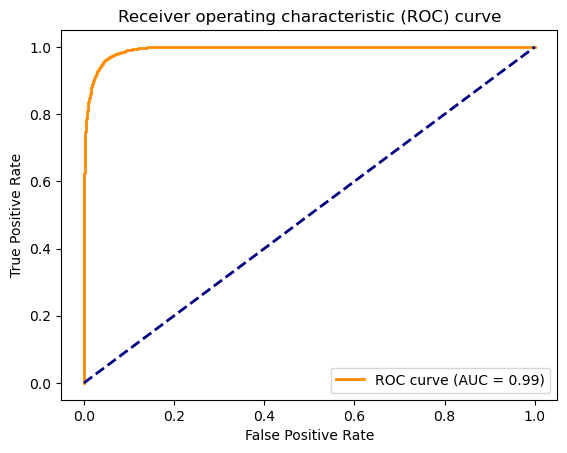

In [139]:
from sklearn.metrics import roc_curve, auc, precision_recall_fscore_support
import torch.nn.functional as F

y_true = data.y[data.test_mask]
y_pred = softmax_x = F.softmax(test_out, dim=1)
test_pred = y_pred.argmax(dim=1).detach()
y_pred = y_pred[:, 1].detach().numpy()
print(torch.sum(test_pred))
print(torch.sum(y_true)/y_true.shape[0])


# Calculate precision, recall, and F1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, test_pred, average='binary')

print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1-score: {:.2f}".format(f1_score))

# Generate ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()